# OASIS MRI Images EDA - Análisis Exploratorio de Imágenes Coronales
## Exploratory Data Analysis for OASIS-2 Longitudinal MRI Dataset

### Objetivo del Análisis

Este notebook realiza un **Análisis Exploratorio de Datos (EDA)** completo sobre imágenes de resonancia magnética (MRI) del cerebro procesadas del dataset OASIS-2. El objetivo principal es:

1. **Identificar patrones visuales y estadísticos** que diferencien entre tres categorías clínicas:
   - **CN (Cognitivamente Normal)**: Pacientes sin deterioro cognitivo
   - **MCI (Deterioro Cognitivo Leve)**: Pacientes con deterioro cognitivo temprano
   - **AD (Enfermedad de Alzheimer)**: Pacientes diagnosticados con Alzheimer

2. **Extraer características cuantitativas** de las imágenes que puedan servir como biomarcadores para:
   - Detección temprana de la enfermedad
   - Diferenciación entre etapas de la enfermedad
   - Validación de modelos de clasificación

3. **Comprender la variabilidad** en las imágenes dentro y entre categorías para:
   - Evaluar la calidad de los datos
   - Identificar posibles outliers o artefactos
   - Establecer bases para preprocesamiento adicional

### Estructura del Análisis

El análisis se divide en las siguientes secciones:

1. **Carga y Exploración Inicial**: Verificación de datos disponibles y carga de imágenes de muestra
2. **Visualización Cualitativa**: Inspección visual de imágenes representativas por categoría
3. **Análisis de Intensidades**: Distribución de valores de píxeles (histogramas)
4. **Extracción de Características**: Cálculo de variables estadísticas para todas las imágenes
5. **Análisis Comparativo**: Comparación de variables entre categorías (boxplots, violin plots)
6. **Análisis de Correlaciones**: Relaciones entre diferentes variables estadísticas
7. **Resumen y Conclusiones**: Síntesis de hallazgos principales

### ¿Qué Buscamos Encontrar?

- **Diferencias en intensidad promedio**: ¿Las imágenes de AD tienen intensidades diferentes que CN/MCI?
- **Variabilidad en contraste**: ¿La desviación estándar de intensidades varía entre categorías?
- **Patrones de distribución**: ¿Los histogramas de intensidad muestran formas distintas?
- **Biomarcadores cuantitativos**: ¿Qué variables estadísticas mejor distinguen entre categorías?
- **Correlaciones entre variables**: ¿Qué características están relacionadas entre sí?

### ¿Qué es la "Intensidad" de una Imagen?

En el contexto de imágenes médicas MRI en escala de grises, la **intensidad** se refiere al **valor de brillo de cada píxel** en la imagen.

**Características importantes:**

1. **Rango de valores**: En nuestras imágenes procesadas, la intensidad va de **0 a 255** (escala de 8 bits)
   - **0** = Negro (ausencia de señal, tejido con poca agua)
   - **255** = Blanco (máxima señal, tejido con mucha agua)
   - **Valores intermedios** = Diferentes tonos de gris

2. **Significado médico en MRI**:
   - **Intensidades bajas (0-85)**: Tejidos con poca señal de agua (hueso, aire, espacios vacíos)
   - **Intensidades medias (85-170)**: Tejido cerebral (materia gris y blanca)
   - **Intensidades altas (170-255)**: Líquido cefalorraquídeo (LCR), ventrículos, espacios llenos de líquido

3. **Variables estadísticas que analizamos**:
   - **Media**: Intensidad promedio de todos los píxeles (indica brillo general)
   - **Mediana**: Valor central de intensidad (menos sensible a valores extremos)
   - **Desviación estándar**: Variabilidad de intensidades (contraste de la imagen)
   - **Varianza**: Medida de dispersión de las intensidades
   - **Mínimo/Máximo**: Rango de intensidades presentes

4. **Por qué es importante**: 
   - Las diferencias en intensidad entre categorías (CN, MCI, AD) pueden reflejar cambios estructurales en el cerebro
   - Por ejemplo, la atrofia cerebral en AD puede manifestarse como cambios en la distribución de intensidades


In [ ]:
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configurar rutas
BASE_DIR = Path().resolve().parent
PROCESSED_DIR = BASE_DIR / "data" / "processed" / "OASIS_2D"

# Verificar si el directorio existe
if not PROCESSED_DIR.exists():
    print(f"❌ El directorio {PROCESSED_DIR} no existe.")
    print("   Por favor, ejecuta primero processOasis.py para procesar las imágenes.")
    categories = {}
else:
    print(f"✓ Directorio encontrado: {PROCESSED_DIR}")
    
    # Categorías disponibles
    categories = {}
    for cat in ["CN", "MCI", "AD"]:
        cat_dir = PROCESSED_DIR / cat
        if cat_dir.exists():
            images = list(cat_dir.glob("*.png"))
            categories[cat] = images
            print(f"✓ {cat}: {len(images)} imágenes")
        else:
            categories[cat] = []
            print(f"⚠️  {cat}: No se encontraron imágenes")

# Estadísticas generales
total_images = sum(len(imgs) for imgs in categories.values())
print(f"\n📊 Total de imágenes procesadas: {total_images}")
print(
    "| CDR     | Interpretación clínica   | Equivalente ML |\n"
    "| ------- | ------------------------ | -------------- |\n"
    "| **0.0** | Normal (sin deterioro)   | **CN**         |\n"
    "| **0.5** | Deterioro cognitivo leve | **MCI**        |\n"
    "| **1.0** | Alzheimer leve           | **AD**         |\n"
    "| **2.0** | Alzheimer moderado       | **AD**         |\n"
    "| **3.0** | Alzheimer severo         | **AD**         |"
)

✓ Directorio encontrado: C:\Users\mmera\OneDrive\Escritorio\ProyectoMineria\proyectoMineria\data\processed\OASIS_2D
✓ CN: 350 imágenes
✓ MCI: 198 imágenes
✓ AD: 48 imágenes

📊 Total de imágenes procesadas: 596
| CDR     | Interpretación clínica   | Equivalente ML |
| ------- | ------------------------ | -------------- |
| **0.0** | Normal (sin deterioro)   | **CN**         |
| **0.5** | Deterioro cognitivo leve | **MCI**        |
| **1.0** | Alzheimer leve           | **AD**         |
| **2.0** | Alzheimer moderado       | **AD**         |
| **3.0** | Alzheimer severo         | **AD**         |


Hay un desbalance en las imagenes que tenermos, pero seguimos teniendo una buena base para detectar fases tempranas.

## 1. Carga y Exploración Inicial de Datos

### ¿Qué se analiza aquí?

En esta sección realizamos la **carga inicial y verificación** de los datos procesados. Es el primer paso crítico del EDA.

### ¿Qué buscamos encontrar?

1. **Disponibilidad de datos**: Verificar que las imágenes procesadas estén correctamente organizadas por categorías (CN, MCI, AD)
2. **Balance del dataset**: Evaluar la distribución de imágenes entre categorías
   - Un dataset balanceado facilita el entrenamiento de modelos
   - Un dataset desbalanceado requiere técnicas especiales (oversampling, undersampling, pesos de clase)
3. **Calidad básica**: Confirmar que las imágenes se cargaron correctamente y tienen dimensiones consistentes

### ¿Por qué es importante?

- **Validación de datos**: Asegura que el preprocesamiento se realizó correctamente
- **Planificación**: El balance de clases informa sobre estrategias de modelado
- **Detección temprana de problemas**: Identifica errores antes de análisis más complejos

### Interpretación de resultados esperados:

- **Distribución balanceada**: Idealmente similar número de imágenes por categoría
- **Distribución desbalanceada**: Común en datos médicos (más controles que casos)
- **Dimensiones consistentes**: Todas las imágenes deberían tener el mismo tamaño (256x128 píxeles en este caso)


In [5]:
# Cargar imágenes de muestra de cada categoría
sample_images = {}

if total_images == 0:
    print("❌ No hay imágenes disponibles para analizar.")
else:
    for cat, img_list in categories.items():
        if len(img_list) > 0:
            try:
                img_path = img_list[0]
                img = np.array(Image.open(img_path).convert('L'))  # Convertir a escala de grises
                sample_images[cat] = img
                print(f"✓ {cat}: Imagen cargada - Shape: {img.shape}, Rango: [{img.min()}, {img.max()}]")
            except Exception as e:
                print(f"❌ Error al cargar imagen de {cat}: {e}")
                sample_images[cat] = None
        else:
            sample_images[cat] = None
    
    print(f"\n✓ Imágenes de muestra cargadas: {len([k for k, v in sample_images.items() if v is not None])} categorías")

✓ CN: Imagen cargada - Shape: (256, 128), Rango: [0, 248]
✓ MCI: Imagen cargada - Shape: (256, 128), Rango: [0, 255]
✓ AD: Imagen cargada - Shape: (256, 128), Rango: [0, 228]

✓ Imágenes de muestra cargadas: 3 categorías


## 2. Visualización Cualitativa de Imágenes de Muestra

### ¿Qué se analiza aquí?

Esta sección muestra **imágenes representativas** de cada categoría clínica para inspección visual directa.

### ¿Qué buscamos encontrar?

1. **Diferencias visuales aparentes** entre categorías:
   - **Atrofia cerebral**: Reducción del tamaño del cerebro en AD
   - **Expansión ventricular**: Aumento de los ventrículos (espacios llenos de líquido)
   - **Cambios en materia gris/blanca**: Alteraciones en la estructura del tejido cerebral
   - **Asimetrías**: Diferencias entre hemisferios izquierdo y derecho

2. **Calidad de las imágenes**:
   - Resolución y claridad
   - Presencia de artefactos
   - Consistencia en el procesamiento

3. **Variabilidad intra-categoría**: 
   - ¿Las imágenes dentro de una misma categoría se ven similares?
   - ¿Hay casos atípicos que requieren revisión?

### ¿Por qué es importante?

- **Validación cualitativa**: Confirma que las categorías tienen sentido visualmente
- **Detección de outliers**: Identifica imágenes que pueden ser problemáticas
- **Contexto clínico**: Ayuda a entender qué estamos midiendo cuantitativamente

### Interpretación esperada:

- **CN (Normal)**: Cerebro con estructura preservada, ventrículos normales
- **MCI (Leve)**: Cambios sutiles, posible ligera atrofia
- **AD (Alzheimer)**: Atrofia más marcada, ventrículos expandidos, pérdida de tejido cerebral


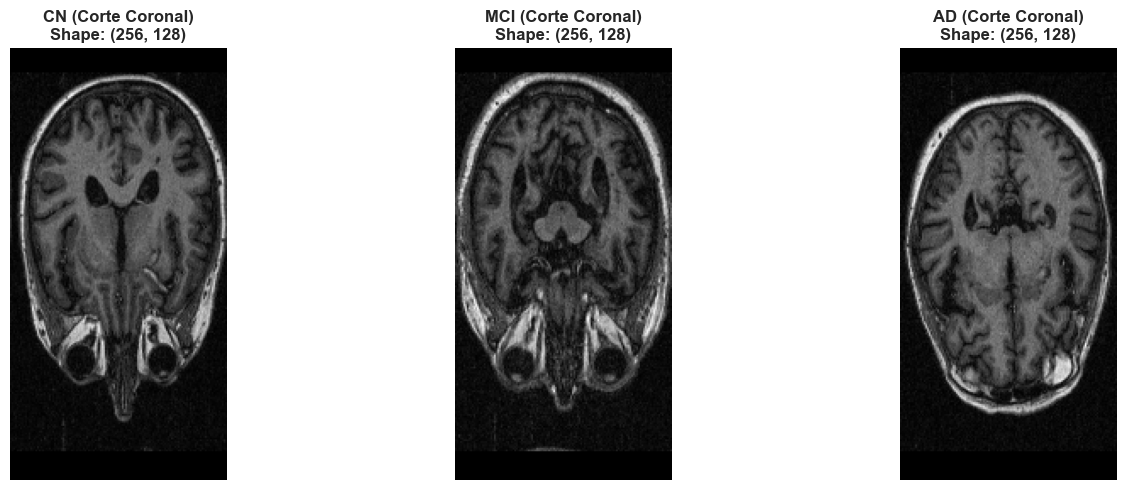

✓ Visualización de imágenes de muestra completada


In [7]:
# Visualizar imágenes de muestra por categoría
if sample_images and any(v is not None for v in sample_images.values()):
    try:
        available_cats = [cat for cat, img in sample_images.items() if img is not None]
        n_cats = len(available_cats)
        
        if n_cats > 0:
            fig, axes = plt.subplots(1, n_cats, figsize=(5*n_cats, 5))
            if n_cats == 1:
                axes = [axes]
            
            for idx, cat in enumerate(available_cats):
                img = sample_images[cat]
                axes[idx].imshow(img, cmap='gray')
                axes[idx].set_title(f'{cat} (Corte Coronal)\nShape: {img.shape}', fontsize=12, fontweight='bold')
                axes[idx].axis('off')
            
            plt.tight_layout()
            plt.show()
            print("✓ Visualización de imágenes de muestra completada")
        else:
            print("⚠️  No hay imágenes disponibles para visualizar")
    except Exception as e:
        print(f"❌ Error al visualizar: {e}")
        import traceback
        traceback.print_exc()
else:
    print("⚠️  No hay imágenes disponibles para visualizar")

## 3. Análisis de Histogramas de Intensidad

### ¿Qué se analiza aquí?

Analizamos la **distribución de valores de intensidad** de los píxeles en las imágenes mediante histogramas. Cada histograma muestra cuántos píxeles tienen cada valor de intensidad (0-255).

### ¿Qué buscamos encontrar?

1. **Forma de la distribución**:
   - **Distribución normal**: Pico central con colas simétricas
   - **Distribución sesgada**: Pico hacia intensidades bajas o altas
   - **Distribución multimodal**: Múltiples picos (puede indicar diferentes tipos de tejido)

2. **Diferencias entre categorías**:
   - **Media/Mediana**: ¿Las imágenes de AD tienen intensidad promedio diferente?
   - **Desviación estándar**: ¿Hay más variabilidad (contraste) en alguna categoría?
   - **Rango**: ¿Alguna categoría tiene valores más extremos?

3. **Patrones específicos**:
   - **Píxeles oscuros (0-85)**: Tejido denso, hueso, espacios vacíos
   - **Píxeles medios (85-170)**: Materia gris y blanca del cerebro
   - **Píxeles claros (170-255)**: Líquido cefalorraquídeo, ventrículos

### ¿Por qué es importante?

- **Biomarcador cuantitativo**: Las diferencias en distribución de intensidades pueden ser indicadores de enfermedad
- **Atrofia cerebral**: En AD, la pérdida de tejido puede cambiar la proporción de píxeles de diferentes intensidades
- **Validación de normalización**: Confirma que el preprocesamiento fue consistente

### Interpretación esperada:

- **CN**: Distribución balanceada, pico en intensidades medias (tejido cerebral)
- **MCI**: Distribución similar a CN pero con posibles cambios sutiles
- **AD**: 
  - Posible aumento en píxeles oscuros (espacios vacíos por atrofia)
  - Posible aumento en píxeles claros (ventrículos expandidos)
  - Posible disminución en píxeles medios (pérdida de tejido cerebral)


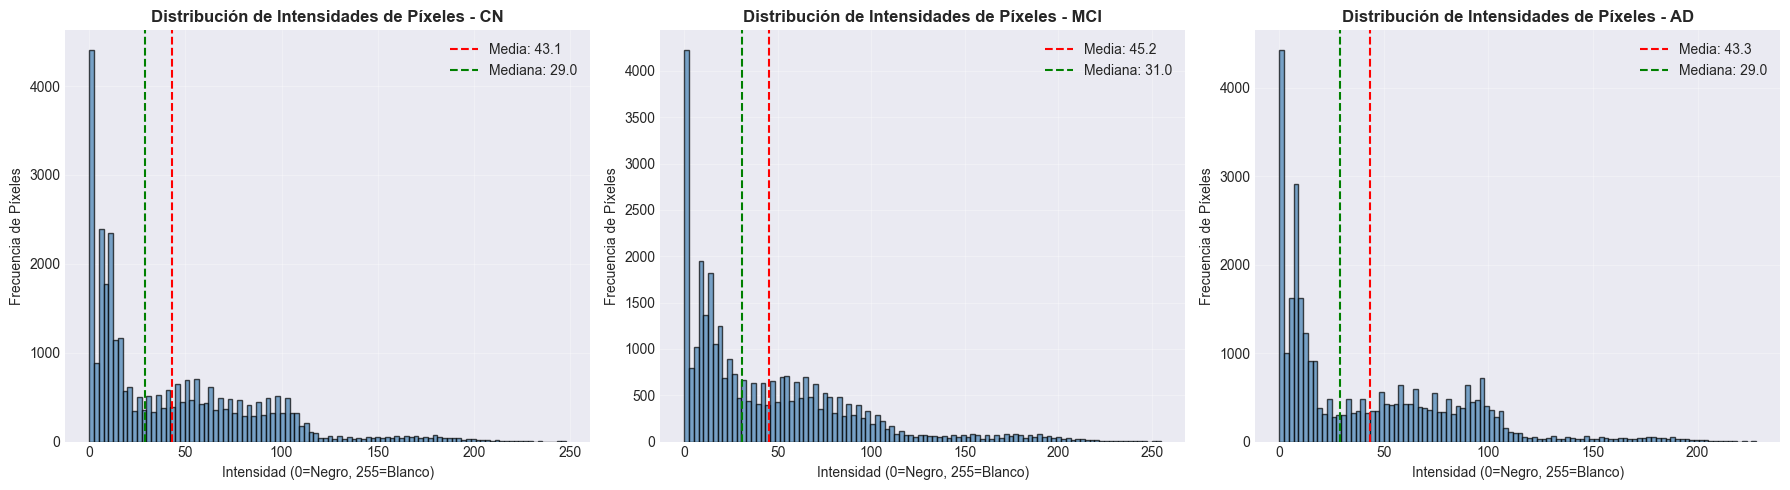


📊 Estadísticas de intensidad por categoría:

CN:
   Media: 43.10
   Mediana: 29.00
   Desviación estándar: 43.31
   Mínimo: 0.00
   Máximo: 248.00

MCI:
   Media: 45.23
   Mediana: 31.00
   Desviación estándar: 45.19
   Mínimo: 0.00
   Máximo: 255.00

AD:
   Media: 43.26
   Mediana: 29.00
   Desviación estándar: 42.61
   Mínimo: 0.00
   Máximo: 228.00


In [9]:
# Histogramas de intensidad por categoría
if sample_images and any(v is not None for v in sample_images.values()):
    try:
        available_cats = [cat for cat, img in sample_images.items() if img is not None]
        
        if len(available_cats) > 0:
            fig, axes = plt.subplots(1, len(available_cats), figsize=(6*len(available_cats), 5))
            if len(available_cats) == 1:
                axes = [axes]
            
            for idx, cat in enumerate(available_cats):
                img = sample_images[cat]
                axes[idx].hist(img.ravel(), bins=100, color='steelblue', edgecolor='black', alpha=0.7)
                axes[idx].set_title(f'Distribución de Intensidades de Píxeles - {cat}', fontsize=12, fontweight='bold')
                axes[idx].set_xlabel('Intensidad (0=Negro, 255=Blanco)', fontsize=10)
                axes[idx].set_ylabel('Frecuencia de Píxeles', fontsize=10)
                axes[idx].grid(True, alpha=0.3)
                
                # Estadísticas
                mean_val = img.mean()
                median_val = np.median(img)
                std_val = img.std()
                axes[idx].axvline(mean_val, color='red', linestyle='--', label=f'Media: {mean_val:.1f}')
                axes[idx].axvline(median_val, color='green', linestyle='--', label=f'Mediana: {median_val:.1f}')
                axes[idx].legend()
            
            plt.tight_layout()
            plt.show()
            
            # Estadísticas por categoría
            print("\n📊 Estadísticas de intensidad por categoría:")
            for cat in available_cats:
                img = sample_images[cat]
                print(f"\n{cat}:")
                print(f"   Media: {img.mean():.2f}")
                print(f"   Mediana: {np.median(img):.2f}")
                print(f"   Desviación estándar: {img.std():.2f}")
                print(f"   Mínimo: {img.min():.2f}")
                print(f"   Máximo: {img.max():.2f}")
        else:
            print("⚠️  No hay imágenes disponibles para el histograma")
    except Exception as e:
        print(f"❌ Error al crear histograma: {e}")
        import traceback
        traceback.print_exc()
else:
    print("⚠️  No hay imágenes disponibles para el histograma")

## Análisis de Variables Estadísticas


## 4. Extracción y Análisis de Variables Estadísticas

### ¿Qué se analiza aquí?

Extraemos **características cuantitativas** de todas las imágenes procesadas. Cada imagen se convierte en un vector de características estadísticas que pueden usarse para análisis comparativo y modelado.

### Variables Extraídas:

1. **Media (`mean`)**: Intensidad promedio de todos los píxeles
   - Indica el "brillo general" de la imagen
   - Valores más altos = imagen más clara en promedio

2. **Desviación Estándar (`std`)**: Variabilidad de intensidades
   - Mide el contraste de la imagen
   - Valores más altos = mayor variación entre píxeles (más contraste)

3. **Mediana (`median`)**: Valor central de intensidad
   - Menos sensible a valores extremos que la media
   - Mejor representante del valor "típico"

4. **Varianza (`var`)**: Dispersión de las intensidades
   - Relacionada con la desviación estándar (var = std²)
   - Indica qué tan "dispersos" están los valores

5. **Mínimo/Máximo**: Rango de intensidades presentes
   - Útil para detectar imágenes con problemas de normalización

6. **Dimensiones (`shape_h`, `shape_w`)**: Tamaño de la imagen
   - Verifica consistencia en el preprocesamiento

7. **Ratio de ceros (`zero_ratio`)**: Proporción de píxeles negros
   - Puede indicar espacios vacíos o atrofia

### ¿Qué buscamos encontrar?

1. **Diferencias significativas** entre categorías en estas variables
2. **Variables más discriminativas**: ¿Qué características mejor separan CN, MCI y AD?
3. **Outliers**: Imágenes con valores estadísticos muy diferentes al resto
4. **Consistencia**: Verificar que todas las imágenes tienen dimensiones similares

### ¿Por qué es importante?

- **Biomarcadores cuantitativos**: Estas variables pueden ser usadas directamente en modelos de clasificación
- **Reducción de dimensionalidad**: En lugar de trabajar con miles de píxeles, trabajamos con ~10 variables
- **Interpretabilidad**: Variables estadísticas son más fáciles de interpretar que píxeles individuales


## 5. Estadísticas Descriptivas por Categoría

### ¿Qué se analiza aquí?

Calculamos **estadísticas descriptivas detalladas** (media, mediana, cuartiles, desviación estándar) para cada variable estadística, agrupadas por categoría clínica.

### ¿Qué buscamos encontrar?

1. **Tendencias centrales**:
   - **Media vs Mediana**: Si difieren mucho, indica distribución sesgada
   - **Comparación entre categorías**: ¿Qué categoría tiene valores más altos/bajos?

2. **Dispersión**:
   - **Desviación estándar**: Variabilidad dentro de cada categoría
   - **Rango intercuartílico (IQR)**: Diferencia entre Q3 y Q1 (robusto a outliers)

3. **Valores extremos**:
   - **Mínimo/Máximo**: Detecta posibles outliers o errores de procesamiento

4. **Distribución**:
   - **Cuartiles (Q1, Q2, Q3)**: Describen la forma de la distribución
   - **Q2 (Mediana)**: Valor que divide los datos en dos mitades iguales

### ¿Por qué es importante?

- **Resumen estadístico**: Proporciona una visión general de los datos
- **Comparación cuantitativa**: Permite comparar objetivamente las categorías
- **Detección de problemas**: Valores extremos pueden indicar errores
- **Base para inferencia**: Estadísticas necesarias para tests estadísticos

### Interpretación esperada:

- Si las medias difieren significativamente entre categorías → Variable potencialmente discriminativa
- Si las desviaciones estándar son muy diferentes → Variabilidad distinta entre grupos
- Si hay valores extremos (muy altos/bajos) → Posibles outliers a investigar


In [14]:
# Cargar y calcular estadísticas para todas las imágenes
def extract_image_features(img_path):
    """Extrae características estadísticas de una imagen"""
    try:
        img = np.array(Image.open(img_path).convert('L'))
        return {
            'mean': img.mean(),
            'std': img.std(),
            'median': np.median(img),
            'min': img.min(),
            'max': img.max(),
            'var': img.var(),
            'shape_h': img.shape[0],
            'shape_w': img.shape[1],
            'pixels': img.size,
            'non_zero': np.count_nonzero(img),
            'zero_ratio': (img.size - np.count_nonzero(img)) / img.size if img.size > 0 else 0
        }
    except Exception as e:
        print(f"Error procesando {img_path}: {e}")
        return None

# Procesar todas las imágenes (muestreo para no sobrecargar)
print("📊 Extrayendo características de las imágenes...")
print("   (Procesando hasta 100 imágenes por categoría para análisis rápido)")

features_data = []
for cat, img_list in categories.items():
    if len(img_list) > 0:
        # Muestrear hasta 100 imágenes por categoría
        sample_size = min(100, len(img_list))
        if len(img_list) > sample_size:
            import random
            sampled_images = random.sample(img_list, sample_size)
        else:
            sampled_images = img_list
        
        print(f"   Procesando {len(sampled_images)} imágenes de {cat}...")
        for img_path in sampled_images:
            features = extract_image_features(img_path)
            if features:
                features['category'] = cat
                features['filename'] = img_path.name
                features_data.append(features)

if features_data:
    df_features = pd.DataFrame(features_data)
    print(f"\n✓ Características extraídas: {len(df_features)} imágenes")
    print(f"   Columnas: {list(df_features.columns)}")
    print(f"\n📋 Resumen por categoría:")
    print(df_features.groupby('category').size())
else:
    print("❌ No se pudieron extraer características")
    df_features = pd.DataFrame()


📊 Extrayendo características de las imágenes...
   (Procesando hasta 100 imágenes por categoría para análisis rápido)
   Procesando 100 imágenes de CN...
   Procesando 100 imágenes de MCI...
   Procesando 48 imágenes de AD...

✓ Características extraídas: 248 imágenes
   Columnas: ['mean', 'std', 'median', 'min', 'max', 'var', 'shape_h', 'shape_w', 'pixels', 'non_zero', 'zero_ratio', 'category', 'filename']

📋 Resumen por categoría:
category
AD      48
CN     100
MCI    100
dtype: int64


## 6. Visualización Comparativa: Boxplots

### ¿Qué se analiza aquí?

Los **boxplots** (diagramas de caja) visualizan la distribución de cada variable estadística comparando las tres categorías clínicas lado a lado.

### ¿Qué buscamos encontrar?

1. **Diferencias en tendencia central**:
   - **Posición de la mediana** (línea central): ¿Qué categoría tiene valores más altos/bajos?
   - **Posición de la caja**: Indica dónde está el 50% central de los datos

2. **Diferencias en dispersión**:
   - **Tamaño de la caja**: Categorías con cajas más grandes tienen más variabilidad
   - **Longitud de los bigotes**: Indica el rango de valores "normales"

3. **Outliers**:
   - **Puntos individuales**: Imágenes con valores estadísticos muy diferentes
   - Pueden ser casos interesantes o errores de procesamiento

4. **Solapamiento entre categorías**:
   - **Cajas que se solapan mucho**: Difícil distinguir categorías con esa variable
   - **Cajas bien separadas**: Variable potencialmente discriminativa

### ¿Por qué es importante?

- **Comparación visual rápida**: Permite ver diferencias de un vistazo
- **Identificación de variables discriminativas**: Variables con cajas bien separadas son mejores para clasificación
- **Detección de outliers**: Fácil identificar valores atípicos
- **Validación de hipótesis**: Confirma si las diferencias esperadas realmente existen

### Interpretación esperada:

- **Variables discriminativas**: Boxplots con cajas claramente separadas entre categorías
- **Variables no discriminativas**: Boxplots con cajas muy solapadas
- **Patrones esperados**:
  - AD podría tener mayor variabilidad (diferentes etapas de la enfermedad)
  - CN podría tener valores más consistentes (grupo control)
  - Diferencias sutiles entre MCI y CN (detección temprana es difícil)


In [15]:
# Estadísticas descriptivas por categoría
if not df_features.empty:
    print("📊 Estadísticas Descriptivas por Categoría\n")
    print("="*80)
    
    # Variables numéricas a analizar
    numeric_vars = ['mean', 'std', 'median', 'var', 'non_zero', 'zero_ratio']
    
    for var in numeric_vars:
        if var in df_features.columns:
            print(f"\n{var.upper()}:")
            print(df_features.groupby('category')[var].describe())
    
    # Resumen general
    print("\n" + "="*80)
    print("\n📈 Resumen General:")
    print(f"   Total de imágenes analizadas: {len(df_features)}")
    print(f"   Dimensiones promedio: {df_features['shape_h'].mean():.0f} x {df_features['shape_w'].mean():.0f}")
    print(f"   Píxeles promedio por imagen: {df_features['pixels'].mean():.0f}")
else:
    print("⚠️  No hay datos disponibles para análisis")


📊 Estadísticas Descriptivas por Categoría


MEAN:
          count       mean        std        min        25%        50%  \
category                                                                 
AD         48.0  42.785692   3.917764  30.673401  40.980751  42.391495   
CN        100.0  41.855411   7.041488   6.000732  39.477631  43.084167   
MCI       100.0  40.536902  10.024664   3.343689  38.768860  42.472717   

                75%        max  
category                        
AD        44.794334  49.666229  
CN        45.878487  52.812531  
MCI       45.622131  56.318939  

STD:
          count       mean       std        min        25%        50%  \
category                                                                
AD         48.0  41.297022  3.389486  29.576386  39.922532  42.015477   
CN        100.0  41.087554  6.399551   6.506485  39.383736  42.215764   
MCI       100.0  39.715308  9.278590   3.690765  38.561172  41.823940   

                75%        max  
category 

## 7. Visualización Comparativa: Violin Plots

### ¿Qué se analiza aquí?

Los **violin plots** combinan un boxplot con un histograma rotado, mostrando tanto la distribución de valores como las estadísticas resumidas.

### ¿Qué buscamos encontrar?

1. **Forma de la distribución**:
   - **Ancho del violín**: Indica la densidad de datos en ese rango
   - **Formas diferentes**: Distribuciones unimodales, bimodales, o sesgadas

2. **Modas (picos)**:
   - **Unimodal**: Un solo pico (distribución normal o sesgada)
   - **Bimodal**: Dos picos (puede indicar subgrupos dentro de la categoría)

3. **Diferencias sutiles**:
   - Más detalle que los boxplots sobre cómo se distribuyen los valores
   - Permite ver si las diferencias son solo en la media o también en la forma

4. **Asimetría**:
   - Violines más anchos a la izquierda = distribución sesgada a la derecha
   - Violines más anchos a la derecha = distribución sesgada a la izquierda

### ¿Por qué es importante?

- **Análisis más detallado**: Proporciona más información que los boxplots
- **Detección de subgrupos**: Formas bimodales pueden indicar subcategorías
- **Validación de normalidad**: Ayuda a decidir qué tests estadísticos usar
- **Comprensión de variabilidad**: Muestra dónde están concentrados los datos

### Interpretación esperada:

- **Distribuciones similares**: Si los violines tienen formas similares, las categorías difieren principalmente en la media
- **Distribuciones diferentes**: Formas distintas pueden indicar procesos patológicos diferentes
- **Bimodalidad**: Puede indicar que una categoría contiene subgrupos (ej: diferentes etapas de AD)


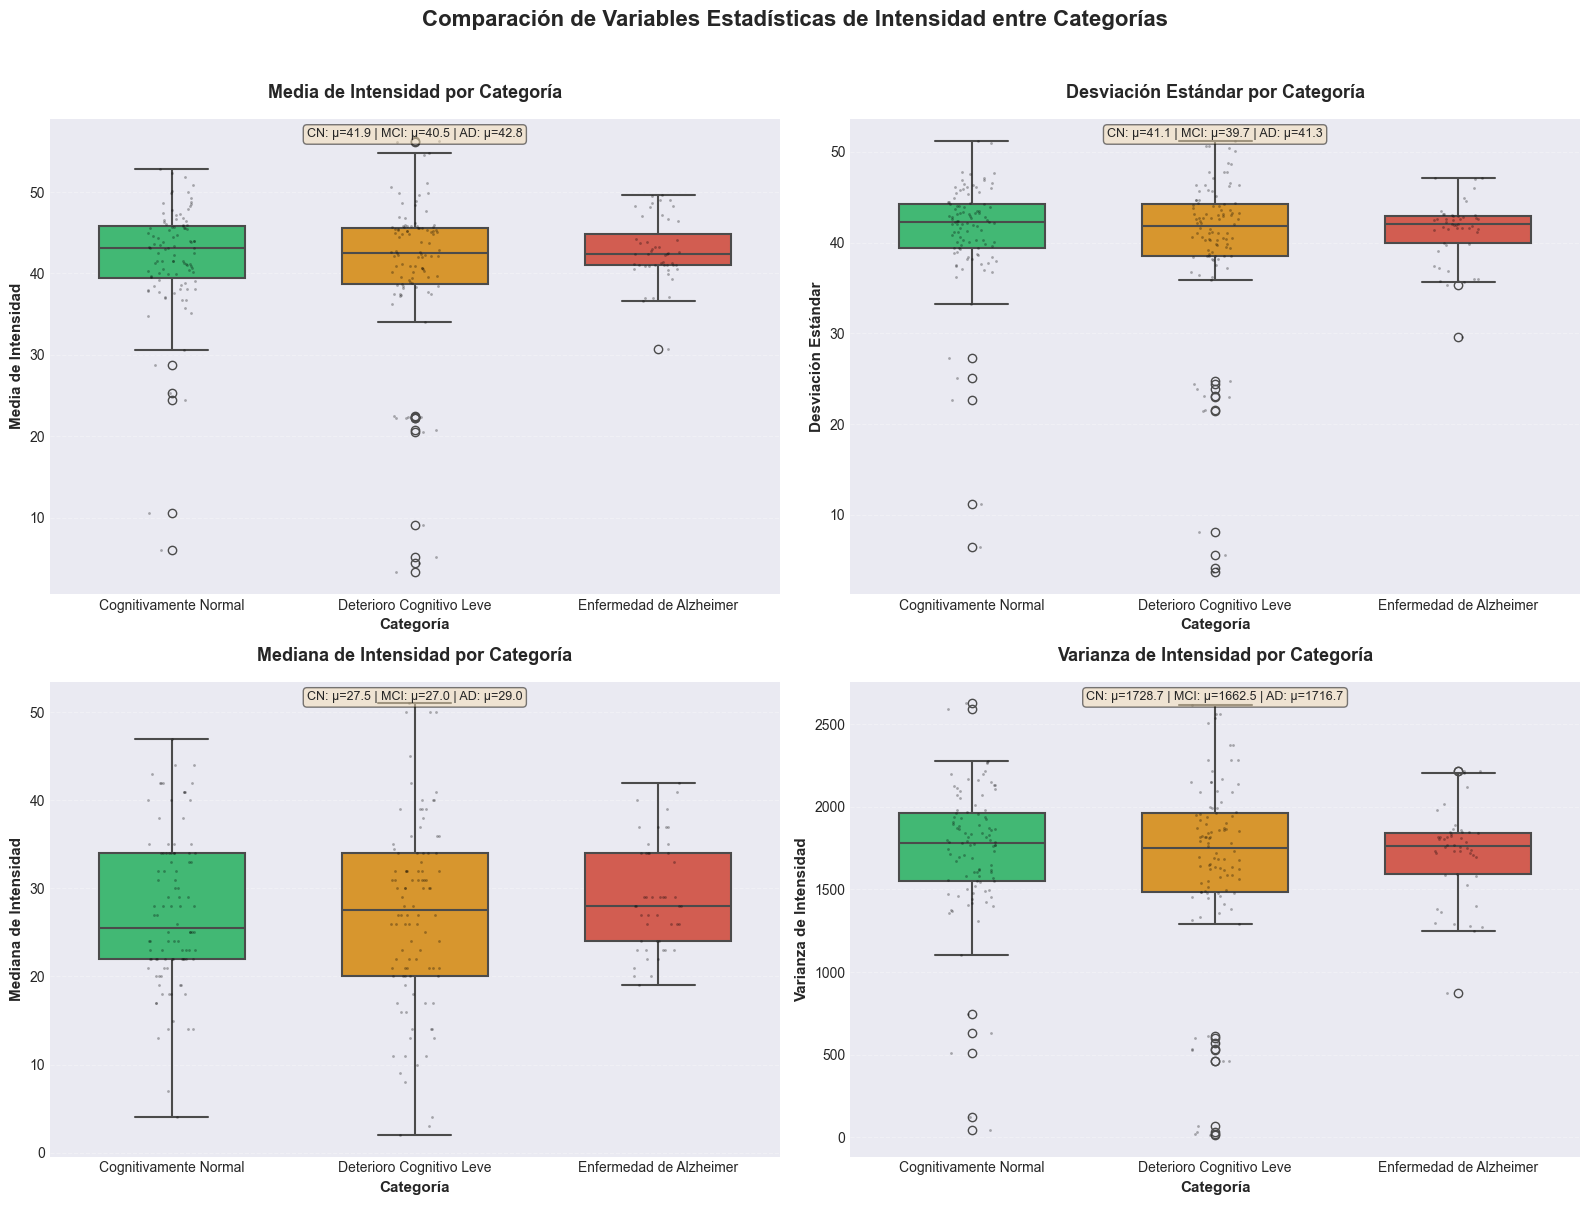

✓ Visualizaciones de distribución mejoradas completadas

📊 Interpretación:
   - Los boxplots muestran la distribución de cada variable estadística
   - La línea central = mediana, los bordes = Q1 y Q3
   - Los puntos muestran valores individuales de las imágenes
   - Los valores en la parte superior muestran la media (μ) por categoría


In [17]:
# Visualización mejorada: Distribución de variables por categoría
if not df_features.empty:
    # Mapeo de nombres de variables a nombres descriptivos
    var_names = {
        'mean': 'Media de Intensidad',
        'std': 'Desviación Estándar',
        'median': 'Mediana de Intensidad',
        'var': 'Varianza de Intensidad'
    }
    
    # Mapeo de categorías a nombres completos
    cat_names = {
        'CN': 'Cognitivamente Normal',
        'MCI': 'Deterioro Cognitivo Leve',
        'AD': 'Enfermedad de Alzheimer'
    }
    
    numeric_vars = ['mean', 'std', 'median', 'var']
    available_vars = [v for v in numeric_vars if v in df_features.columns]
    
    if available_vars:
        # Crear figura con subplots
        n_vars = len(available_vars)
        n_cols = 2
        n_rows = (n_vars + n_cols - 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 6*n_rows))
        # Asegurar que axes sea siempre una lista/array plano
        if isinstance(axes, np.ndarray):
            axes = axes.flatten()
        elif not isinstance(axes, (list, np.ndarray)):
            axes = [axes]
        
        # Paleta de colores para las categorías
        palette = {'CN': '#2ecc71', 'MCI': '#f39c12', 'AD': '#e74c3c'}
        
        for idx, var in enumerate(available_vars[:4]):  # Máximo 4 variables
            ax = axes[idx]
            
            # Crear boxplot con seaborn para mejor estilo
            sns.boxplot(data=df_features, x='category', y=var, ax=ax, 
                       palette=palette, width=0.6, linewidth=1.5)
            
            # Agregar stripplot para mostrar puntos individuales (opcional, con transparencia)
            sns.stripplot(data=df_features, x='category', y=var, ax=ax,
                         color='black', alpha=0.3, size=2, jitter=True)
            
            # Personalizar título y etiquetas
            var_display = var_names.get(var, var.upper())
            ax.set_title(f'{var_display} por Categoría', 
                        fontsize=13, fontweight='bold', pad=15)
            ax.set_xlabel('Categoría', fontsize=11, fontweight='bold')
            ax.set_ylabel(var_display, fontsize=11, fontweight='bold')
            
            # Actualizar etiquetas de categorías
            ax.set_xticklabels([cat_names.get(cat.get_text(), cat.get_text()) 
                               for cat in ax.get_xticklabels()], 
                              fontsize=10, rotation=0, ha='center')
            
            # Agregar grid para mejor legibilidad
            ax.grid(True, alpha=0.3, linestyle='--', axis='y')
            ax.set_axisbelow(True)
            
            # Agregar estadísticas básicas como texto
            stats_text = []
            for cat in df_features['category'].unique():
                cat_data = df_features[df_features['category'] == cat][var]
                mean_val = cat_data.mean()
                stats_text.append(f"{cat}: μ={mean_val:.1f}")
            
            # Agregar texto con estadísticas en la parte superior
            ax.text(0.5, 0.98, ' | '.join(stats_text), 
                   transform=ax.transAxes, fontsize=9, 
                   verticalalignment='top', horizontalalignment='center',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        # Ocultar subplots no utilizados
        for idx in range(len(available_vars), len(axes)):
            axes[idx].set_visible(False)
        
        # Título general
        fig.suptitle('Comparación de Variables Estadísticas de Intensidad entre Categorías', 
                     fontsize=16, fontweight='bold', y=1.00)
        plt.tight_layout(rect=[0, 0, 1, 0.98])
        plt.show()
        
        print("✓ Visualizaciones de distribución mejoradas completadas")
        print("\n📊 Interpretación:")
        print("   - Los boxplots muestran la distribución de cada variable estadística")
        print("   - La línea central = mediana, los bordes = Q1 y Q3")
        print("   - Los puntos muestran valores individuales de las imágenes")
        print("   - Los valores en la parte superior muestran la media (μ) por categoría")
    else:
        print("⚠️  No hay variables numéricas disponibles para visualizar")
else:
    print("⚠️  No hay datos disponibles para visualizar")


## 8. Análisis de Dimensiones de las Imágenes

### ¿Qué se analiza aquí?

Verificamos la **consistencia en las dimensiones** (altura y ancho en píxeles) de todas las imágenes procesadas.

### ¿Qué buscamos encontrar?

1. **Consistencia dimensional**:
   - ¿Todas las imágenes tienen las mismas dimensiones?
   - ¿Hay variaciones que puedan afectar el análisis?

2. **Distribución de dimensiones**:
   - Si hay variación, ¿cómo se distribuye?
   - ¿Hay imágenes con dimensiones atípicas?

3. **Calidad del preprocesamiento**:
   - Dimensiones consistentes indican buen preprocesamiento
   - Variaciones pueden indicar problemas en el pipeline

### ¿Por qué es importante?

- **Requisito para modelos**: La mayoría de modelos de deep learning requieren imágenes del mismo tamaño
- **Comparabilidad**: Imágenes del mismo tamaño permiten comparaciones justas
- **Detección de errores**: Dimensiones inconsistentes pueden indicar problemas en el procesamiento

### Interpretación esperada:

- **Dimensiones consistentes**: Todas las imágenes deberían tener el mismo tamaño (ej: 256x128)
- **Sin variación**: Idealmente, todas las imágenes tienen exactamente las mismas dimensiones
- **Si hay variación**: Puede requerir redimensionamiento adicional antes del modelado


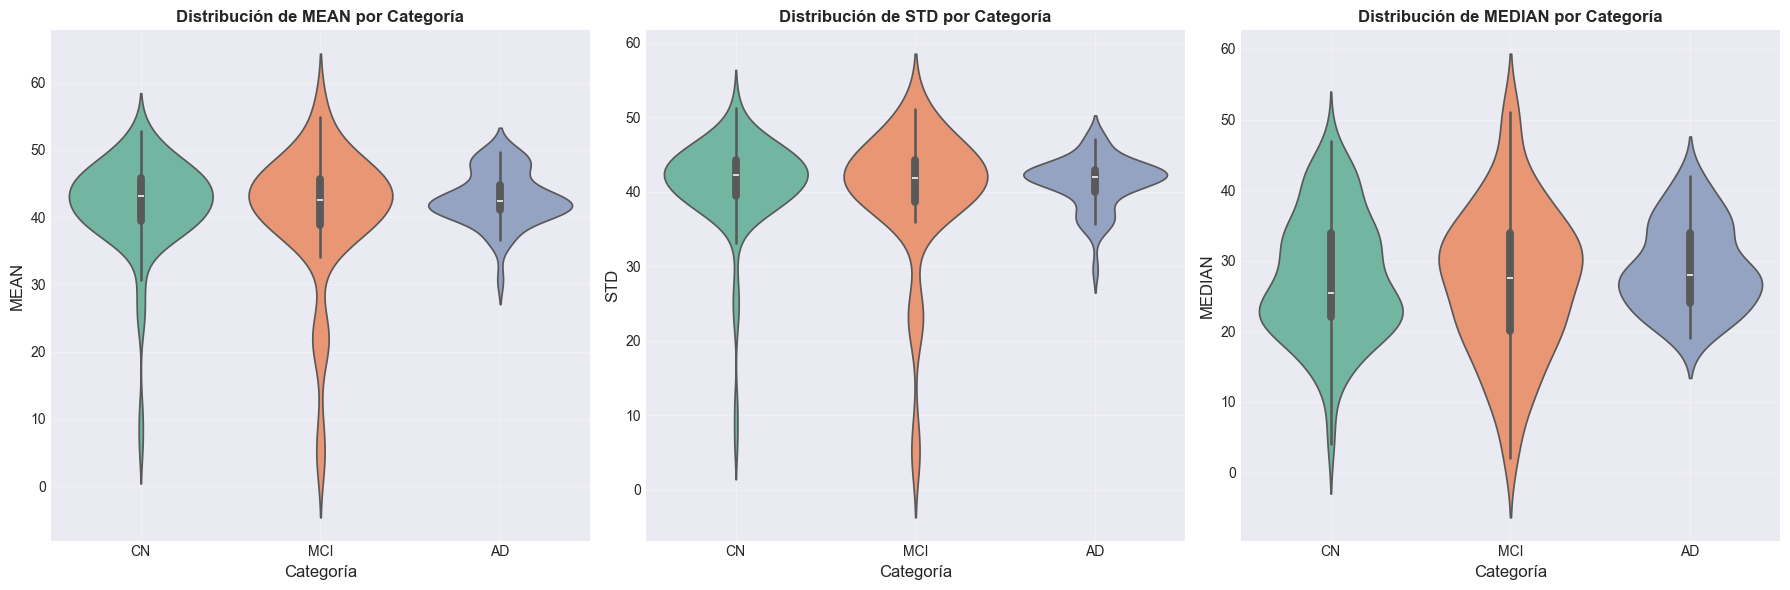

✓ Violin plots completados


In [18]:
# Visualización: Violin plots para comparación detallada
if not df_features.empty:
    numeric_vars = ['mean', 'std', 'median']
    available_vars = [v for v in numeric_vars if v in df_features.columns]
    
    if available_vars:
        fig, axes = plt.subplots(1, len(available_vars), figsize=(6*len(available_vars), 6))
        if len(available_vars) == 1:
            axes = [axes]
        
        for idx, var in enumerate(available_vars):
            sns.violinplot(data=df_features, x='category', y=var, ax=axes[idx], palette='Set2')
            axes[idx].set_title(f'Distribución de {var.upper()} por Categoría', fontweight='bold')
            axes[idx].set_xlabel('Categoría', fontsize=12)
            axes[idx].set_ylabel(var.upper(), fontsize=12)
            axes[idx].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print("✓ Violin plots completados")
    else:
        print("⚠️  No hay variables disponibles para violin plots")
else:
    print("⚠️  No hay datos disponibles")


## 9. Matriz de Correlación entre Variables

### ¿Qué se analiza aquí?

Analizamos las **correlaciones** entre las diferentes variables estadísticas extraídas de las imágenes.

### ¿Qué buscamos encontrar?

1. **Variables altamente correlacionadas** (r > 0.7 o r < -0.7):
   - **Redundancia**: Variables que miden lo mismo
   - **Multicolinealidad**: Puede ser problemática en algunos modelos
   - **Oportunidad de reducción**: Se puede eliminar una variable sin perder información

2. **Variables independientes** (r ≈ 0):
   - **Información complementaria**: Cada variable aporta información única
   - **Ideal para modelos**: Variables independientes son más informativas

3. **Correlaciones negativas** (r < 0):
   - **Relaciones inversas**: Cuando una aumenta, la otra disminuye
   - **Ejemplo**: Media y ratio de ceros podrían estar negativamente correlacionadas

4. **Patrones de correlación**:
   - **Clusters**: Variables que se correlacionan entre sí forman grupos
   - Pueden representar diferentes aspectos de la imagen (brillo, contraste, estructura)

### ¿Por qué es importante?

- **Selección de características**: Identifica variables redundantes para eliminar
- **Comprensión de relaciones**: Ayuda a entender cómo se relacionan las características
- **Optimización de modelos**: Evita usar variables redundantes que no aportan información adicional
- **Reducción de dimensionalidad**: Puede guiar técnicas como PCA

### Interpretación esperada:

- **Media y Mediana**: Probablemente altamente correlacionadas (ambas miden tendencia central)
- **Std y Varianza**: Perfectamente correlacionadas (var = std²)
- **Dimensiones (h, w)**: Pueden estar correlacionadas si las imágenes mantienen proporción
- **Variables independientes**: Idealmente, cada variable aporta información única


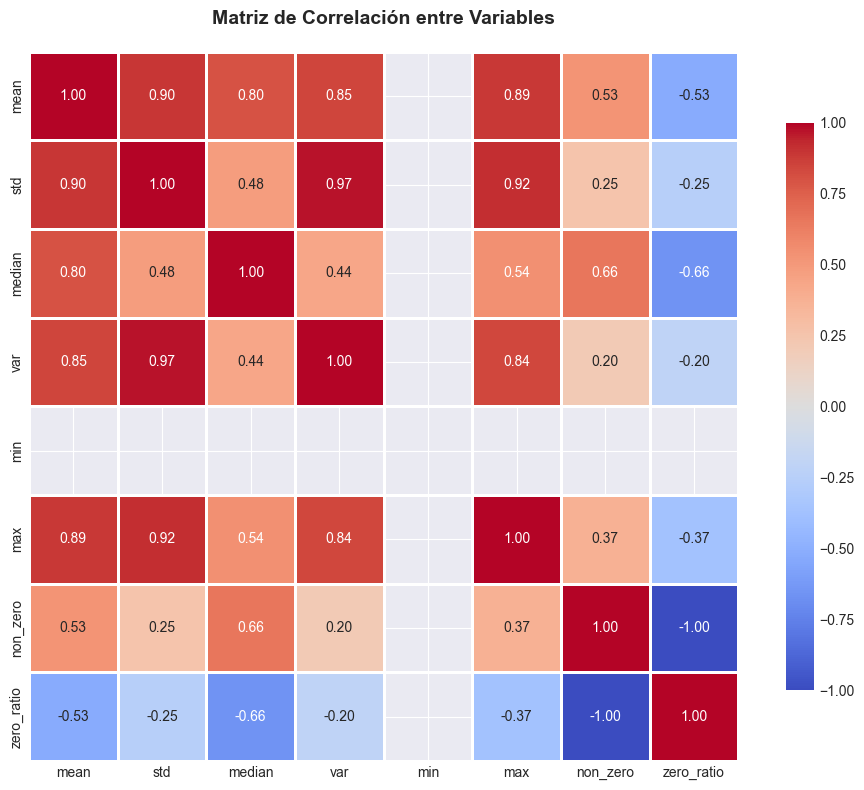

✓ Matriz de correlación generada


In [20]:
# Matriz de correlación entre variables
if not df_features.empty:
    numeric_cols = ['mean', 'std', 'median', 'var', 'min', 'max', 'non_zero', 'zero_ratio']
    available_cols = [col for col in numeric_cols if col in df_features.columns]
    
    if len(available_cols) > 1:
        corr_matrix = df_features[available_cols].corr()
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                    square=True, linewidths=1, cbar_kws={"shrink": 0.8})
        plt.title('Matriz de Correlación entre Variables', fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()
        
        print("✓ Matriz de correlación generada")
    else:
        print("⚠️  No hay suficientes variables numéricas para matriz de correlación")
else:
    print("⚠️  No hay datos disponibles")


## 10. Resumen Final y Conclusiones del Análisis

### ¿Qué se analiza aquí?

Sintetizamos todos los hallazgos del análisis exploratorio en un **resumen ejecutivo** con las conclusiones principales.

### ¿Qué buscamos encontrar?

1. **Hallazgos principales**:
   - ¿Qué variables muestran diferencias significativas entre categorías?
   - ¿Qué categorías son más fáciles de distinguir?
   - ¿Hay patrones consistentes en los datos?

2. **Calidad del dataset**:
   - Balance de clases
   - Consistencia en dimensiones
   - Presencia de outliers o problemas

3. **Implicaciones para modelado**:
   - ¿Qué variables deberían usarse en modelos de clasificación?
   - ¿Se necesita balanceo de clases?
   - ¿Hay suficiente información para distinguir las categorías?

4. **Próximos pasos**:
   - ¿Qué análisis adicionales serían útiles?
   - ¿Qué preprocesamiento adicional se necesita?
   - ¿Qué modelos serían apropiados?

### ¿Por qué es importante?

- **Síntesis**: Consolida toda la información del EDA en conclusiones accionables
- **Documentación**: Registra los hallazgos para referencia futura
- **Toma de decisiones**: Informa decisiones sobre preprocesamiento y modelado
- **Comunicación**: Facilita comunicar resultados a otros investigadores

### Interpretación esperada:

- **Variables discriminativas identificadas**: Lista de características que mejor distinguen categorías
- **Calidad del dataset evaluada**: Balance, consistencia, y posibles problemas
- **Recomendaciones claras**: Próximos pasos basados en los hallazgos
- **Conclusiones clínicas**: Relación entre hallazgos estadísticos y significado médico


In [21]:
# Resumen final del análisis
if not df_features.empty:
    print("="*80)
    print("📊 RESUMEN FINAL DEL ANÁLISIS")
    print("="*80)
    
    print(f"\n📁 Total de imágenes analizadas: {len(df_features)}")
    print(f"\n📊 Distribución por categoría:")
    cat_counts = df_features['category'].value_counts()
    for cat, count in cat_counts.items():
        pct = (count / len(df_features)) * 100
        print(f"   {cat}: {count} imágenes ({pct:.1f}%)")
    
    print(f"\n📐 Dimensiones de las imágenes:")
    print(f"   Altura: {df_features['shape_h'].min():.0f} - {df_features['shape_h'].max():.0f} píxeles")
    print(f"   Ancho: {df_features['shape_w'].min():.0f} - {df_features['shape_w'].max():.0f} píxeles")
    
    print(f"\n📈 Estadísticas clave por categoría:")
    key_stats = df_features.groupby('category')[['mean', 'std', 'median']].mean()
    print(key_stats.round(2))
    
    print("\n" + "="*80)
    print("✓ Análisis completado exitosamente")
else:
    print("⚠️  No se pudo completar el análisis - no hay datos disponibles")


📊 RESUMEN FINAL DEL ANÁLISIS

📁 Total de imágenes analizadas: 248

📊 Distribución por categoría:
   CN: 100 imágenes (40.3%)
   MCI: 100 imágenes (40.3%)
   AD: 48 imágenes (19.4%)

📐 Dimensiones de las imágenes:
   Altura: 256 - 256 píxeles
   Ancho: 128 - 128 píxeles

📈 Estadísticas clave por categoría:
           mean    std  median
category                      
AD        42.79  41.30   29.04
CN        41.86  41.09   27.49
MCI       40.54  39.72   27.00

✓ Análisis completado exitosamente
